In [1]:
import numpy as np
import pandas as pd
from dLoader import DataLoader
from dLoader.utils import regroup
import matplotlib.pyplot as plt

In [2]:
# stocks_data = pd.read_json('Database/keeper.json', orient='index')
# search_mask = stocks_data['Latest Price'].between(0, 10) & (stocks_data['Length in Database'] > (250 * 6))
# tickers = stocks_data[search_mask].index.to_list()
# print('There are {} tickers match the search.'.format(len(tickers)))

In [3]:
def get_dates(start, end):
    cols = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    dates = pd.concat([pd.Series(pd.date_range(start, end, freq="W-MON")) + pd.DateOffset(i) \
                       for i in range(len(cols))], axis=1)
    dates.columns = cols
    return dates

def get_prices_by_DOW(df, dates, indicator='Close'):
    prices = dates.copy()
    for col in dates.columns:
        price = df.loc[df.index.isin(dates[col])][indicator]
        mask = prices[col].isin(price.index)
        prices.loc[mask, col] = price.values
        prices.loc[~mask, col] = np.nan
    return prices

In [4]:
def PivotPoints(data):
    p = data.loc[:, ['High', 'Low', 'Close']].mean(1)
    d = data['High'] - data['Low']
    r1 = (p * 2) - data['Low']
    r2 = p + d
    s1 = (p * 2) - data['High']
    s2 = p - d
    df = pd.concat([s2, s1, p, r1, r2], axis=1)
    df.columns = ['Support2', 'Support1', 'Pivot', 'Resistance1', 'Resistance2']
    return df

In [5]:
def add_bands(data, period=20, m=2):
    mid = data.loc[:, ['High', 'Low', 'Close']].mean(1).ewm(alpha=1/period, min_periods=period)
    std = mid.std()
    data['Mid Band'] = mid.mean()
    data['Upper Band'] = data['Mid Band'] + (m * std)
    data['Lower Band'] = data['Mid Band'] - (m * std)

In [41]:
data = DataLoader('AAPL').get_data('2017-01-01', '2020-12-31')
data['EMA'] = data['Close'].ewm(alpha=1/200, min_periods=200).mean()
data = data.dropna()

In [42]:
period = 7
m = 3
tr = pd.concat([data['High'] - data['Low'], 
                data['High'] - data['Close'].shift(1), 
                data['Low'] - data['Close'].shift(1)], axis=1).abs().max(1)
atr = tr.ewm(alpha=1/(period - 1), min_periods=period).mean()
hl = data.loc[:, ['High', 'Low', 'Close']].mean(1)
flb = np.array(hl - (m * atr))
fub = np.array(hl + (m * atr))

close = np.array(data['Close'])
low = np.array(data['Low'])
high = np.array(data['High'])
ema = np.array(data['EMA'])

trend = np.array([False] * len(data))
buy_signal = np.array([np.nan] * len(data))
sell_signal = np.array([np.nan] * len(data))

buy_at = 0
holding = False
still_trend = False
sell_at = 0
stop_at = 0
trades = []

for i in range(1, len(data)):
    if close[i] > fub[i-1]:
        trend[i] = True
        still_trend = True
    elif close[i] < flb[i-1]:
        trend[i] = False
        still_trend = False
    else:
        trend[i] = trend[i-1]

        if trend[i] and flb[i] < flb[i-1]:
            flb[i] = flb[i-1]
        if not trend[i] and fub[i] > fub[i-1]:
            fub[i] = fub[i-1]
    
    if trend[i]:
        fub[i] = np.nan
    else:
        flb[i] = np.nan
    
    if not holding:
        if trend[i] and close[i] > ema[i]:
            buy_at = close[i]
            buy_signal[i] = close[i] * .99
            sell_at = buy_at * 1.03
            holding = True
    else:
        if not trend[i]:
            sell_signal[i] = close[i] * 1.01
            trades.append(close[i] / buy_at - 1)
            holding=False

if len(trades) > 0:
    arr = np.array(trades)
    num_trade = len(arr)
    above_zero = (arr > 0).mean()
    cap_gain = np.prod(arr + 1) - 1
    print(num_trade, above_zero, cap_gain)

10 0.7 1.601856619345785


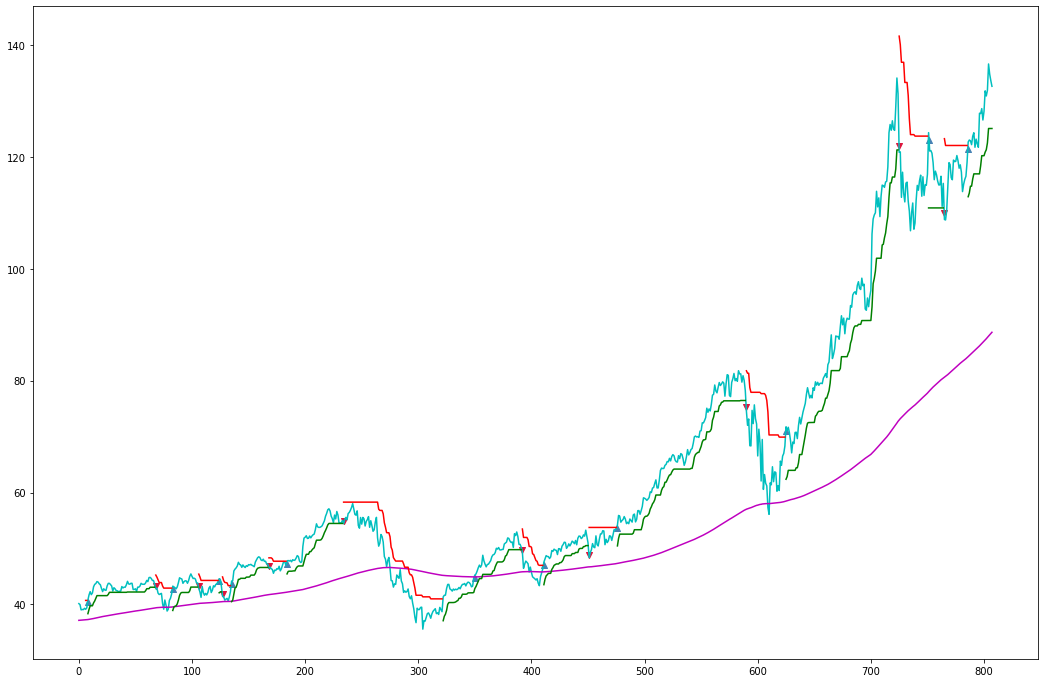

In [43]:
plt.figure(figsize=(18, 12))
plt.plot(close, 'c')
plt.plot(ema, 'm')
plt.plot(flb, 'g')
plt.plot(fub, 'r')
plt.scatter(x=np.arange(len(close)), y=buy_signal, c='steelblue', marker='^')
plt.scatter(x=np.arange(len(close)), y=sell_signal, c='crimson', marker='v')
plt.show()

In [ ]:
"this is a test"